## Import Packages

In [180]:
# By: Darren Upton
# Modeled on Code By: Kishan Rajput

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras import datasets, layers, models
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
import pickle
import seaborn as sns

#Stuff for ML
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import random
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_curve

from keras import backend as K

from matplotlib.colors import LogNorm

import scipy


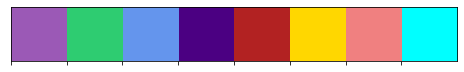

In [2]:
best_colors = ["#9b59b6",
               "#2ecc71","cornflowerblue","indigo",#"darkorange",
               "firebrick","gold","lightcoral",
               "cyan"#"magenta"
              ]
sns.set_palette(sns.color_palette(best_colors))
sns.palplot(sns.color_palette(best_colors))

## Import Data

In [3]:
%%time

#Full
raw_sim_df = pd.read_csv("Sim_CSV/Sim_Pencil_AllEvents_TID1.csv")
raw_bkg_df = pd.read_csv("Sim_CSV/Sim_Pencil_Bkg.csv")

#Cher Arrays
raw_sim_cher = pd.read_csv("Sim_CSV/Sim_Pencil_CherChannels_AllEvents_TID1.csv", 
                           names=np.core.defchararray.add(np.array(16*["Cher"]), np.arange(0,16,1).astype(str)))
raw_sim_cher["pid"] = raw_sim_df["pid"]

raw_bkg_cher = pd.read_csv("Sim_CSV/Bkg_CherChannels.csv", 
                           names=np.core.defchararray.add(np.array(16*["Cher"]), np.arange(0,16,1).astype(str)))
raw_bkg_cher["pid"] = raw_bkg_df["pid"]

#raw_sim_df["Npesum"] = raw_sim_df.iloc[:,]

sim_df = raw_sim_df #[raw_sim_df["GEM00_Edep"]>35e-6]#[(raw_sim_df["PreShSum"]>0)].reset_index(drop=1)
bkg_df = raw_bkg_df #[GEM00_Edep >35e-6]#[(raw_bkg_df["PreShSum"]>0)&(raw_bkg_df["ShowerSum"]>0)].reset_index(drop=1)

sim_cher = raw_sim_cher
bkg_cher = raw_bkg_cher

sim_df

CPU times: user 1min 9s, sys: 10.4 s, total: 1min 20s
Wall time: 1min 20s


,# rate,vx,vy,vz,px,py,pz,p,pid,PreShP,...,GEM01_Etot,GEM11_n,GEM11_np,GEM11_Edep,GEM11_Edep2,GEM11_Edep3,GEM11_Etot,Npesum,theta,NCh
0,0.0003,0.0,0.0,0.0,-0.234481,2.871560e-17,0.721657,0.758795,11.0,743.066040,...,0.041197,1.0,47.0,0.000904,0.000904,0.000904,0.036460,27.0,18.000007,8.0
1,0.0003,0.0,0.0,0.0,-2.981923,3.651803e-16,9.177417,9.649707,11.0,6910.143066,...,0.058279,1.0,30.0,0.002967,0.002967,0.002967,0.032077,35.0,17.999995,10.0
2,0.0003,0.0,0.0,0.0,-0.911992,1.116868e-16,2.806822,2.951267,11.0,2877.891602,...,0.048772,1.0,33.0,0.000547,0.000547,0.000547,0.024543,25.0,17.999995,7.0
3,0.0003,0.0,0.0,0.0,-2.397427,2.936001e-16,7.378521,7.758236,11.0,7744.224609,...,0.031277,1.0,53.0,0.000286,0.000286,0.000286,0.020833,25.0,17.999995,8.0
4,0.0003,0.0,0.0,0.0,-2.853923,3.495048e-16,8.783473,9.235490,11.0,7368.849121,...,0.034688,1.0,74.0,0.000818,0.000818,0.000818,0.026032,33.0,17.999995,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000987,20.0000,0.0,0.0,0.0,-1.573952,1.927535e-16,4.844126,5.093416,-211.0,5085.679688,...,0.028306,1.0,5.0,0.000463,0.000463,0.000463,0.034769,6.0,17.999995,1.0
5000988,20.0000,0.0,0.0,0.0,-2.191752,2.684122e-16,6.745520,7.092659,-211.0,7085.326660,...,0.019737,1.0,5.0,0.000079,0.000079,0.000079,0.033819,21.0,18.000007,5.0
5000989,20.0000,0.0,0.0,0.0,-1.127889,1.381266e-16,3.471285,3.649925,-211.0,3640.323242,...,0.025422,1.0,5.0,0.000477,0.000477,0.000477,0.021713,0.0,18.000007,0.0
5000990,20.0000,0.0,0.0,0.0,-2.760364,3.380470e-16,8.495525,8.932724,-211.0,8924.052734,...,0.029711,1.0,5.0,0.000736,0.000736,0.000736,0.029953,31.0,17.999995,7.0


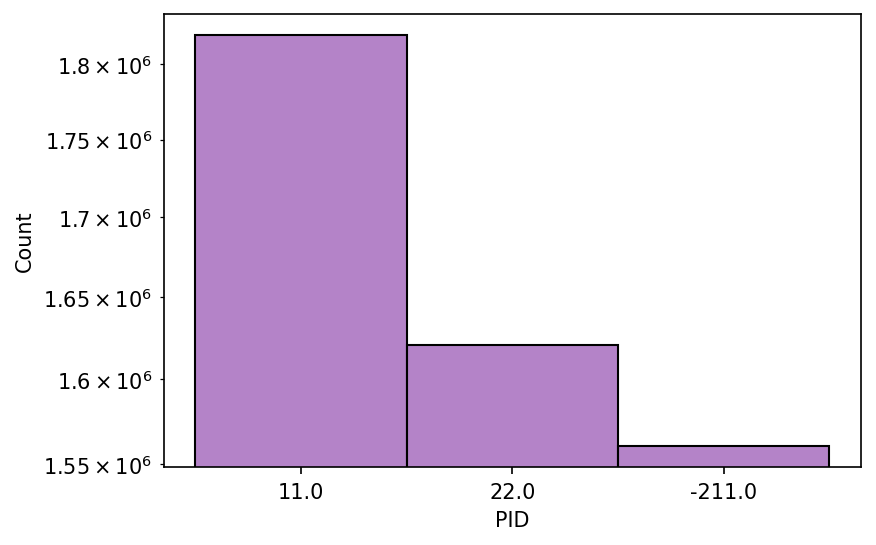

In [4]:
plt.figure(dpi=150)
plt.xlabel("PID")
sns.histplot(sim_df, x=sim_df["pid"].astype(str))#, weights="# rate")
plt.yscale("log")


# Plots

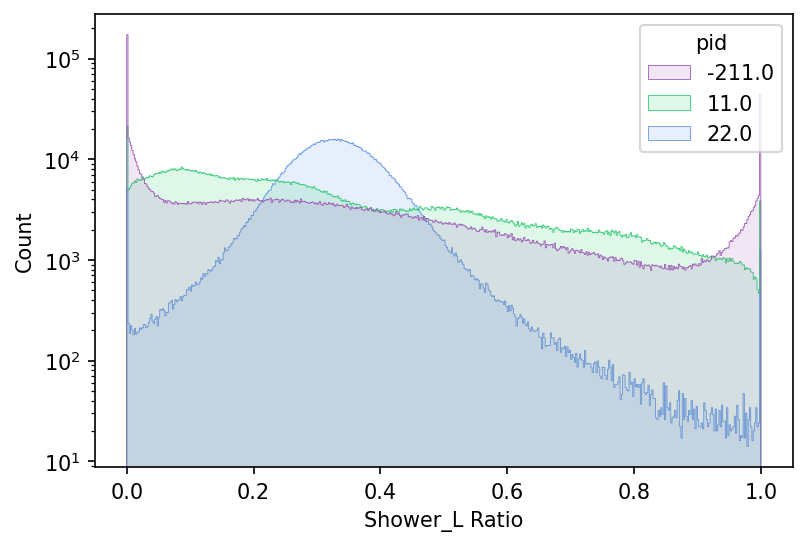

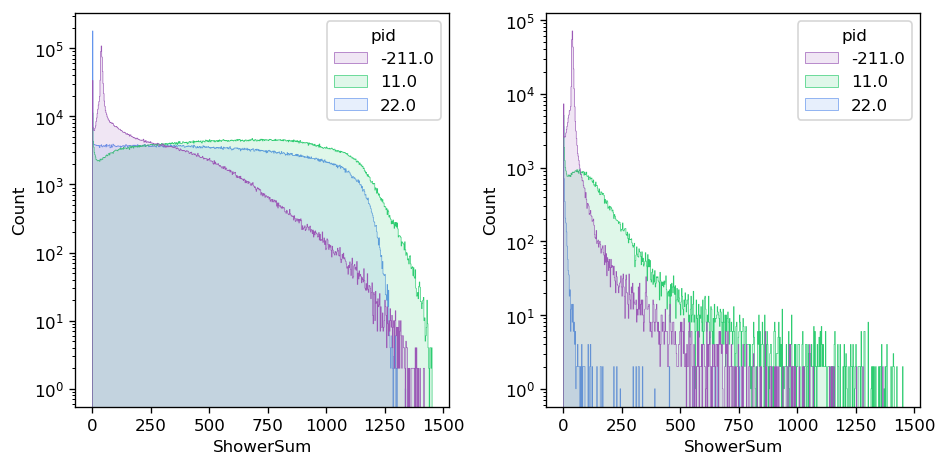

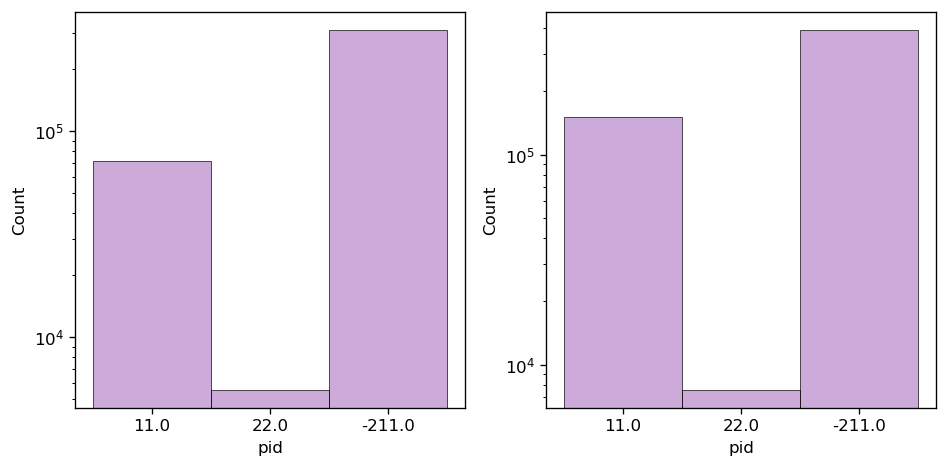

In [5]:

plt.figure(dpi=150)
plt.xlabel("Shower_L Ratio")
sns.histplot(sim_df, x=(sim_df["Shower_l"]/sim_df["ShowerSum"]), 
             hue="pid", element="step", binwidth=.002,
             linewidth=.4, palette=sns.color_palette(best_colors[:-5]), alpha=0.15)
plt.yscale("log")



plt.figure(figsize=(8,4), dpi=120)
width = 0.05
keeps = ((((sim_df["Shower_l"]/sim_df["ShowerSum"]) > (1-width)) | ((sim_df["Shower_l"]/sim_df["ShowerSum"]) < width))
         & (((sim_df["Shower_t"]/sim_df["ShowerSum"]) > (1-width)) | ((sim_df["Shower_t"]/sim_df["ShowerSum"]) < width))
         & (((sim_df["Shower_r"]/sim_df["ShowerSum"]) > (1-width)) | ((sim_df["Shower_r"]/sim_df["ShowerSum"]) < width))
        )

plt.subplot(1,2,1)
plt.xlabel("ShowerSum")
sns.histplot(sim_df, x="ShowerSum",
             hue="pid", element="step", binwidth=2.5,
             linewidth=.4, palette=sns.color_palette(best_colors[:-5]), alpha=0.15)
plt.yscale("log")

plt.subplot(1,2,2)
plt.xlabel("ShowerSum")
sns.histplot(sim_df[keeps], x="ShowerSum",
             hue="pid", element="step", binwidth=2.5,
             linewidth=.4, palette=sns.color_palette(best_colors[:-5]), alpha=0.15)
plt.yscale("log")
plt.tight_layout()
plt.show()



plt.figure(figsize=(8,4), dpi=120)

width = 0.05
keeps = ((((sim_df["Shower_l"]/sim_df["ShowerSum"]) > (1-width)) | ((sim_df["Shower_l"]/sim_df["ShowerSum"]) < width))
         & (((sim_df["Shower_t"]/sim_df["ShowerSum"]) > (1-width)) | ((sim_df["Shower_t"]/sim_df["ShowerSum"]) < width))
         & (((sim_df["Shower_r"]/sim_df["ShowerSum"]) > (1-width)) | ((sim_df["Shower_r"]/sim_df["ShowerSum"]) < width))
        )

width = 0.1
keeps2 = ((((sim_df["Shower_l"]/sim_df["ShowerSum"]) > (1-width)) | ((sim_df["Shower_l"]/sim_df["ShowerSum"]) < width))
         & (((sim_df["Shower_t"]/sim_df["ShowerSum"]) > (1-width)) | ((sim_df["Shower_t"]/sim_df["ShowerSum"]) < width))
         & (((sim_df["Shower_r"]/sim_df["ShowerSum"]) > (1-width)) | ((sim_df["Shower_r"]/sim_df["ShowerSum"]) < width))
        )

plt.subplot(1,2,1)
plt.xlabel("pid")
sns.histplot(sim_df[keeps], x=(sim_df["pid"][keeps]).astype(str),
             #element="step", #binwidth=2.5,
             linewidth=.4, #palette=sns.color_palette(best_colors[:-1]), 
             alpha=0.5)
plt.yscale("log")

plt.subplot(1,2,2)
plt.xlabel("pid")
sns.histplot(sim_df[keeps2], x=(sim_df["pid"][keeps2]).astype(str),
             #element="step", #binwidth=2.5,
             linewidth=.4, #palette=sns.color_palette(best_colors[:-1]), 
             alpha=0.5)
#plt.ylim(10**4,10**6)
plt.yscale("log")
plt.tight_layout()

# MLP

## Samples

In [6]:
sim_df.columns#[[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -3,-1]]

Index(['# rate', 'vx', 'vy', 'vz', 'px', 'py', 'pz', 'p', 'pid', 'PreShP',
       'PreShP_e', 'PreShPx', 'PreShPy', 'PreShPz', 'PreShtheta', 'PreShSum',
       'PreSh_l', 'PreSh_r', 'PreSh_t', 'ShowerSum', 'Shower_l', 'Shower_r',
       'Shower_t', 'SC_A_P', 'SC_A_Eendsum', 'SC_A_Eend', 'SC_D_P',
       'SC_D_Eendsum', 'SC_D_Eend', 'SC_C_P', 'SC_C_Eendsum', 'SC_C_Eend',
       'SC_B_P', 'SC_B_Eendsum', 'SC_B_Eend', 'SPD_P', 'SPD_Eendsum',
       'SPD_Eend', 'LASPD_P', 'LASPD_Eendsum', 'LASPD_Eend', 'GEM00_n',
       'GEM00_np', 'GEM00_Edep', 'GEM00_Edep2', 'GEM00_Edep3', 'GEM00_Etot',
       'GEM10_n', 'GEM10_np', 'GEM10_Edep', 'GEM10_Edep2', 'GEM10_Edep3',
       'GEM10_Etot', 'GEM01_n', 'GEM01_np', 'GEM01_Edep', 'GEM01_Edep2',
       'GEM01_Edep3', 'GEM01_Etot', 'GEM11_n', 'GEM11_np', 'GEM11_Edep',
       'GEM11_Edep2', 'GEM11_Edep3', 'GEM11_Etot', 'Npesum', 'theta', 'NCh'],
      dtype='object')

In [98]:
%%time
#Number of background events per data event
n_bkg = 1
keeps = (sim_df["pid"]!=22) & ((sim_df["p"]>3.0)&(sim_df["p"]<=3.5))

data_np = (sim_df[keeps]).to_numpy()#(sim_df["pid"]!=111) sim_df[(sim_df["ShowerSum"]>1) & (sim_df["pid"]!=111) ].to_numpy()
bkg_np = ((raw_bkg_df.sample(n=n_bkg*len(sim_df[keeps]), random_state=42, replace=1)).to_numpy()).reshape((len(sim_df[keeps]),-1,
                                                                                                           len(raw_bkg_df.columns))).sum(axis=1)
#cher_np = Cher_df.to_numpy()

#X = data_np[:,[0, 4,5,6,7, 15,16,17,18, 19,21,22, 24,27,30,33, 39, 41,47,53,59, -7,-5]] #with momentum #np.delete(data_np, np.arange(0,9,1), 1)
               #15, 19, 24,27,30,33, 39, 41,47,53,59, -2]]

#X = data_np[:,[7, 15,16,17,18, 19,20,21,22]] #p+ ECal
X = data_np[:,[15,16,17,18, 19,20,21,22]] # ECal

#X = data_np[:,[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -3,-1]] #No clustering
#X_bkg = bkg_np[:,[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -2,-1]]

#X = data_np[:,[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -7,-5, -4,-3, -2,-1]] #With clustering
#X_Cher = cher_np[:,np.arange(0,16,1)]

#Full_X = np.column_stack([X,X_Cher])

Full_X = (X)# + X_bkg)*np.random.normal(1,.1,(X).shape)#*(np.random.random((X).shape)>0.1)

#Get Labels
y = data_np[:,8].astype(int)
y[y==11] = 0
#y += np.round(np.random.uniform(0,1,len(y))).astype(int)
#y[y==22] = 1
y[y==-211] = 1

scaler = MinMaxScaler()

#Features Engineering Stuff
#data = np.column_stack([Full_X[:,0], 
#                        np.divide(Full_X[:,[2,3,4]],Full_X[:,[1]],where=Full_X[:,[1]]!=0, out=0*Full_X[:,[2,3,4]]),
#                        np.divide(Full_X[:,[6,7,8]],Full_X[:,[5]],where=Full_X[:,[5]]!=0, out=0*Full_X[:,[6,7,8]]),
#                        scaler.fit_transform(Full_X[:,[1,5]])])
# print(data.min(), data.max())

#p_bin + ECal
#data = np.column_stack([np.round(Full_X[:,0]*2)/2,#True Momentum bin
#                        #scaler.fit_transform(), #scaled momentum bin
#                        scaler.fit_transform(np.column_stack([np.round(Full_X[:,0]*2)/2, Full_X[:,1:]]))]) #Scaled ECal vars

data = scaler.fit_transform(Full_X)

#train_data, test_data, train_labels, test_labels = train_test_split(data[:, :-1], data[:, -1], test_size=0.25, random_state=42)
train_data, test_data, train_labels, test_labels = train_test_split(data, y, test_size=0.3, random_state=42)

print("Train:", len(train_data))
print("Test:", len(test_data))

Train: 116171
Test: 49788
CPU times: user 616 ms, sys: 580 ms, total: 1.2 s
Wall time: 1.05 s


### Notes
***
| Type | Cuts | Train | Test |
| --- | --- | --- | --- |
| Baseline | None | 2028163 | 1352109 |
| GeV2 | (0,2] | 369818 | 92455 |
| GeV4 | (2,4] | 525732 | 131434 |
| GeV6 | (4,6] | 542003 | 135501 |
| GeV8 | (6,8] | 548651 | 137163 |
| GeV10 | (8,10] | 552416 | 138104 |
| GeV12 | (10,12] | 165596 | 41399 |


## Training

Epoch 1/80
233/233 [==============================] - 4s 10ms/step - loss: 0.0991 - accuracy: 0.9693 - val_loss: 0.1151 - val_accuracy: 0.9890
Epoch 2/80
233/233 [==============================] - 2s 9ms/step - loss: 0.0460 - accuracy: 0.9889 - val_loss: 0.0440 - val_accuracy: 0.9870
Epoch 3/80
233/233 [==============================] - 2s 9ms/step - loss: 0.0408 - accuracy: 0.9893 - val_loss: 0.0363 - val_accuracy: 0.9899
Epoch 4/80
233/233 [==============================] - 2s 9ms/step - loss: 0.0387 - accuracy: 0.9900 - val_loss: 0.0321 - val_accuracy: 0.9907
Epoch 5/80
233/233 [==============================] - 2s 10ms/step - loss: 0.0381 - accuracy: 0.9899 - val_loss: 0.0314 - val_accuracy: 0.9907
Epoch 6/80
233/233 [==============================] - 2s 9ms/step - loss: 0.0359 - accuracy: 0.9905 - val_loss: 0.0288 - val_accuracy: 0.9918
Epoch 7/80
233/233 [==============================] - 2s 9ms/step - loss: 0.0349 - accuracy: 0.9909 - val_loss: 0.0311 - val_accuracy: 0.9904
Epoc

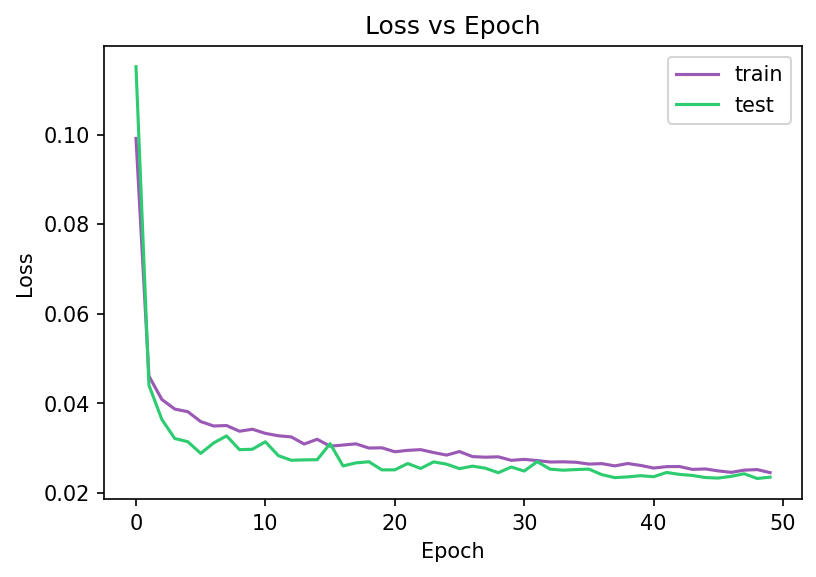

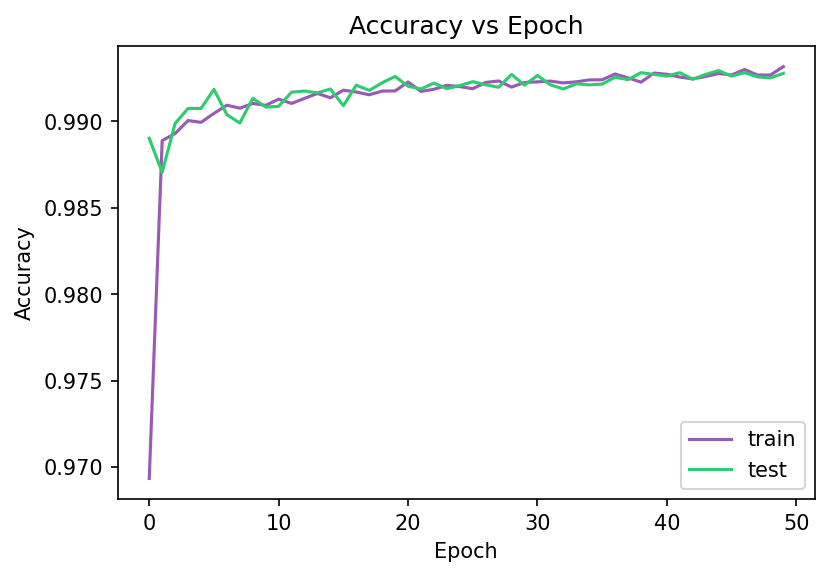

CPU times: user 7min 55s, sys: 1min 1s, total: 8min 56s
Wall time: 1min 49s


In [99]:
%%time

momentum_bin = "3.0_3.5"

version = f"SULI_Week3_PencilMomentum_{momentum_bin}"#VeryHighBkg_New" #With_Momentum" #_Momentum_ShSum_Cut"

################
# Model Building
################

mom_35GeV = tf.keras.Sequential([
    Input(data[:,1:].shape[-1]),
    #Dense(1024, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(512, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(256, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(128, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(64, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(32, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(16, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(8, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(len(np.unique(y)), activation="softmax")
])


opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

mom_35GeV.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True),
              metrics=['accuracy'])


###############
train_model = mom_35GeV
################

###############
# Training
###############

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=.01, factor=0.9, patience=4, min_lr=1e-5)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=12) #use 1e-4, 10
un_cts = np.unique(y, return_counts=1)

history = train_model.fit(train_data[:,1:], train_labels, batch_size=500, epochs=80,
                          #class_weight = {int(un_cts[0][0]):1/un_cts[1][0], int(un_cts[0][1]):1/un_cts[1][1], int(un_cts[0][2]):1/un_cts[1][2]},
                          #{0:1.5, 1:30, 2:8}, #{0:10, 1:1, 2:10, 3:1}, #{0:1.5, 1:30, 2:8
                          #sample_weight = np.abs((train_labels-1.3)**-1),#train_labels,
                          callbacks=[reduce_lr,early_stop],
                          validation_data=(test_data[:,1:], test_labels))


###############
# Results
###############
plt.figure(dpi=150)
plt.title("Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.plot(np.arange(len(history.history["loss"])),history.history["loss"], label="train")
plt.plot(np.arange(len(history.history["val_loss"])),history.history["val_loss"], label="test")
plt.legend()
plt.savefig(f"Plots/Sim_Loss_{version}.pdf")
plt.show()

plt.figure(dpi=150)
plt.title("Accuracy vs Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.plot(np.arange(len(history.history["accuracy"])),history.history["accuracy"], label="train")
plt.plot(np.arange(len(history.history["val_accuracy"])),history.history["val_accuracy"], label="test")
plt.legend()
plt.savefig(f"Plots/Sim_Accuracy_{version}.pdf")
plt.show()

CPU times: user 4.01 s, sys: 590 ms, total: 4.6 s
Wall time: 1.79 s


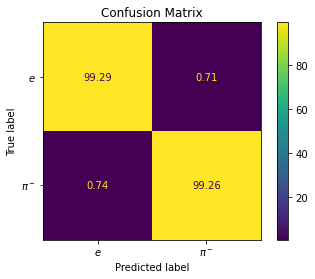

In [100]:
%%time

predictions = train_model.predict(test_data[:,1:])
results = np.argmax(predictions, axis=1)

#e_eff = ((results==0)*(test_labels==0)).sum()/(test_labels==0).sum()
#pi_rej = 1-(((results==0)*(test_labels==2)).sum()/(test_labels==2).sum())

#print("e Efficiency:",e_eff)
#print("Pi Rejection:",pi_rej)

cm = confusion_matrix(test_labels,results)#, sample_weight=test_data[:,0])
cm_percent = (cm)/(np.repeat(cm.sum(axis=1),2,axis=0).reshape(2,2))*100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,display_labels=["$e$","$\pi^-$"])#[11,22,211]) #"$\gamma$",
disp.plot(values_format='.2f')

plt.title(f"Confusion Matrix")#: $e$:{e_eff*100: .1f}% & $\pi$:{pi_rej*100: .1f}%")

plt.savefig(f"Plots/Sim_Confusion_{version}.pdf")



# Comparing Results

In [20]:
def get_eff_rej(predictions, test_labels, e_pid=0):
    spacing = 1000
    #prob_limits = np.linspace(.40,1, int(2e3))
    prob_limits = np.logspace(-.32,0, int(3e4))
    
    #Get Events
    e_events = (test_labels==e_pid)
    pi_events = (test_labels!=e_pid)
    
    #Get Nums
    num_e = (test_labels==e_pid).sum()
    num_pi = (test_labels!=e_pid).sum()

    true_e, false_e = [], []
    for p_val in prob_limits:
        pids = predictions[:,0]>p_val

        true_e.append((((pids==e_pid)*e_events).sum())/num_e)
        false_e.append((((pids==e_pid)*pi_events).sum())/num_pi)
    
    return np.array(true_e), np.array(false_e)


In [19]:
%%time
#full_predictions = full_model.predict(test_data[:,1:])
#full_true_e, full_false_e = get_eff_rej(full_predictions, test_labels)
#np.savetxt('ML_Probs/ECal_MomSlice/ML_ECal_prob_full.out', np.column_stack([full_true_e, full_false_e]), delimiter=',')

#feat_eng_predictions = feat_eng_model.predict(test_data[:,1:])
#feat_eng_true_e, feat_eng_false_e = get_eff_rej(feat_eng_predictions, test_labels)
#np.savetxt('ML_Probs/ECal_MomSlice/ML_ECal_prob_full_FeatEng.out', np.column_stack([full_true_e, full_false_e]), delimiter=',')

#mom_bin_predictions = mom_bins.predict(test_data[:,1:])
#mom_bin_true_e, mom_bin_false_e = get_eff_rej(mom_bin_predictions, test_labels)
#np.savetxt('ML_Probs/ECal_MomSlice/ML_ECal_prob_full_MomBin.out', np.column_stack([mom_bin_true_e, mom_bin_false_e]), delimiter=',')


#GeV05_predictions = mom_05GeV.predict(test_data[:,1:])
#GeV05_true_e, GeV05_false_e = get_eff_rej(GeV05_predictions, test_labels)
#np.savetxt('ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV05.out', np.column_stack([GeV05_true_e, GeV05_false_e]), delimiter=',')
GeV05_true_e, GeV05_false_e = np.hsplit(np.loadtxt("ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV05.out", delimiter=","),2)

#GeV10_predictions = mom_10GeV.predict(test_data[:,1:])
#GeV10_true_e, GeV10_false_e = get_eff_rej(GeV10_predictions, test_labels)
#np.savetxt('ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV10.out', np.column_stack([GeV10_true_e, GeV10_false_e]), delimiter=',')
GeV10_true_e, GeV10_false_e = np.hsplit(np.loadtxt("ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV10.out", delimiter=","),2)

#GeV15_predictions = mom_15GeV.predict(test_data[:,1:])
#GeV15_true_e, GeV15_false_e = get_eff_rej(GeV15_predictions, test_labels)
#np.savetxt('ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV15.out', np.column_stack([GeV15_true_e, GeV15_false_e]), delimiter=',')
GeV15_true_e, GeV15_false_e = np.hsplit(np.loadtxt("ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV15.out", delimiter=","),2)

#GeV20_predictions = mom_20.predict(test_data[:,1:])
#GeV20_true_e, GeV20_false_e = get_eff_rej(GeV20_predictions, test_labels)
#np.savetxt('ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV20.out', np.column_stack([GeV20_true_e, GeV20_false_e]), delimiter=',')
GeV20_true_e, GeV20_false_e = np.hsplit(np.loadtxt("ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV20.out", delimiter=","),2)

#GeV25_predictions = mom_25GeV.predict(test_data[:,1:])
#GeV25_true_e, GeV25_false_e = get_eff_rej(GeV25_predictions, test_labels)
#np.savetxt('ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV25.out', np.column_stack([GeV25_true_e, GeV25_false_e]), delimiter=',')
GeV25_true_e, GeV25_false_e = np.hsplit(np.loadtxt("ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV25.out", delimiter=","),2)

#GeV30_predictions = mom_30GeV.predict(test_data[:,1:])
#GeV30_true_e, GeV30_false_e = get_eff_rej(GeV30_predictions, test_labels)
#np.savetxt('ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV30.out', np.column_stack([GeV30_true_e, GeV30_false_e]), delimiter=',')
GeV30_true_e, GeV30_false_e = np.hsplit(np.loadtxt("ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV30.out", delimiter=","),2)

#GeV35_predictions = mom_35GeV.predict(test_data[:,1:])
#GeV35_true_e, GeV35_false_e = get_eff_rej(GeV35_predictions, test_labels)
#np.savetxt('ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV35.out', np.column_stack([GeV35_true_e, GeV35_false_e]), delimiter=',')
GeV35_true_e, GeV35_false_e = np.hsplit(np.loadtxt("ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV35.out", delimiter=","),2)

#GeV40_predictions = mom_40GeV.predict(test_data[:,1:])
#GeV40_true_e, GeV40_false_e = get_eff_rej(GeV40_predictions, test_labels)
#np.savetxt('ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV40.out', np.column_stack([GeV40_true_e, GeV40_false_e]), delimiter=',')
GeV40_true_e, GeV40_false_e = np.hsplit(np.loadtxt("ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV40.out", delimiter=","),2)

#GeV45_predictions = GeV45_model.predict(test_data[:,1:])
#GeV45_true_e, GeV45_false_e = get_eff_rej(GeV45_predictions, test_labels)
#np.savetxt('ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV45.out', np.column_stack([GeV45_true_e, GeV45_false_e]), delimiter=',')
#GeV45_true_e, GeV45_false_e = np.hsplit(np.loadtxt("ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV45.out", delimiter=","),2)

#GeV50_predictions = GeV50_model.predict(test_data[:,1:])
#GeV50_true_e, GeV50_false_e = get_eff_rej(GeV50_predictions, test_labels)
#np.savetxt('ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV50.out', np.column_stack([GeV50_true_e, GeV50_false_e]), delimiter=',')
#GeV50_true_e, GeV50_false_e = np.hsplit(np.loadtxt("ML_Probs/ECal_MomSlice/ML_ECal_prob_GeV50.out", delimiter=","),2)


CPU times: user 1.07 s, sys: 30.1 ms, total: 1.1 s
Wall time: 1.09 s


## Comparison Plots

<timed exec>:13: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:27: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:27: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:27: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:27: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:27: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:27: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:27: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:13: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:27: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:27: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:27: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:27: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:27: RuntimeW

CPU times: user 2min 39s, sys: 750 ms, total: 2min 40s
Wall time: 2min 39s


[]

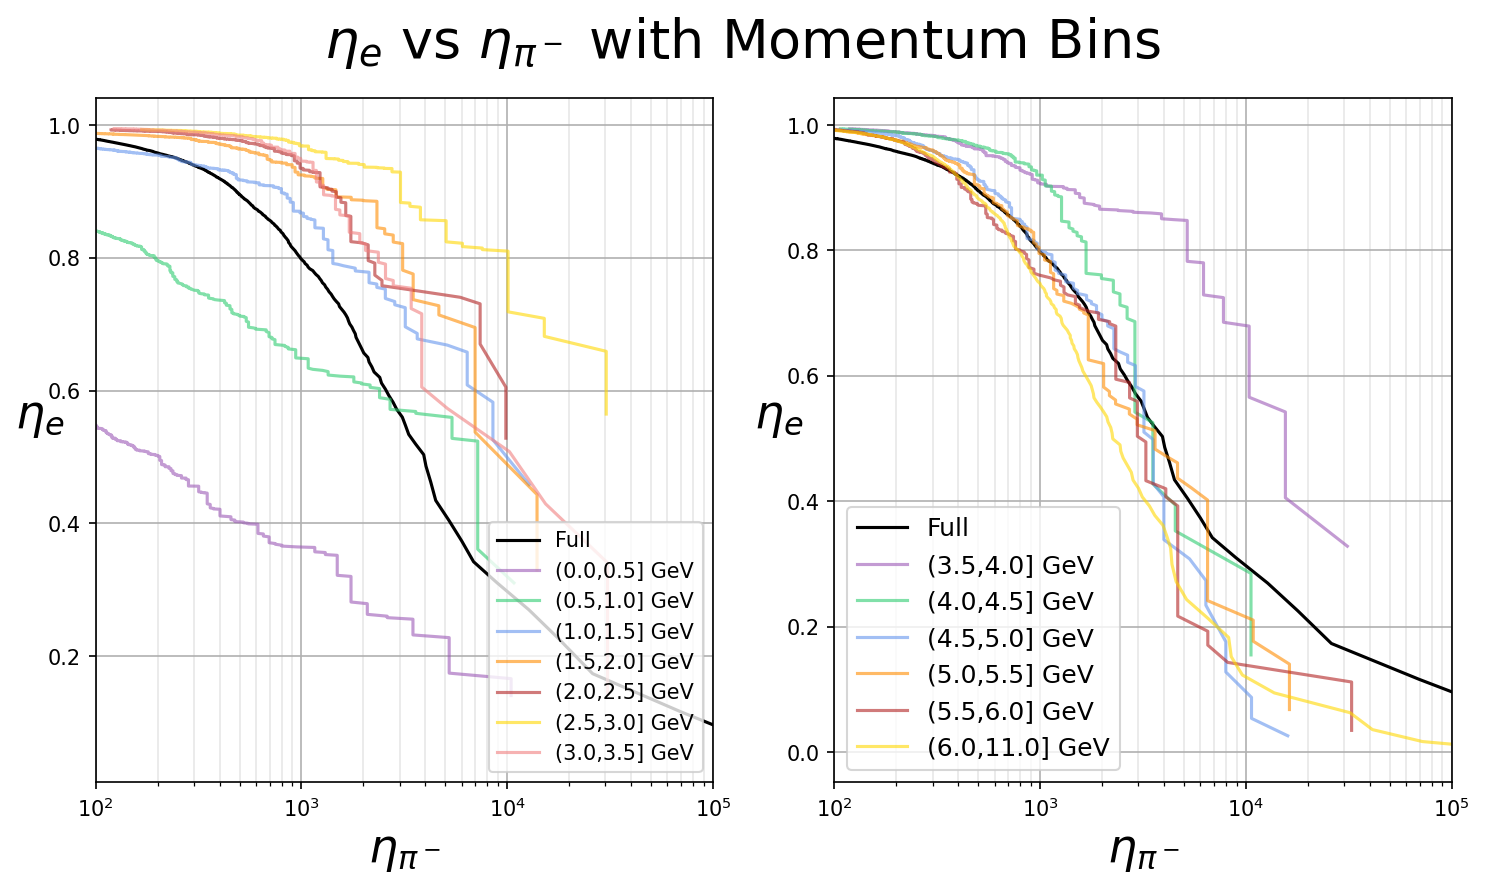

In [17]:
%%time

fig = plt.figure(dpi=150, figsize=(10,6))
plt.suptitle("$\eta_e$ vs $\eta_{\pi^-}$ with Momentum Bins", fontsize=26)#$\pi^-$ Rejection")


#plt.plot(1/(1-full_false_e),1-full_true_e, label="Full", c="black")

slices = np.append(np.arange(0,6.1,.5),np.array(11))
for i in range(len(slices)-1):
    
    if i%7 == 0:
        if i!=0: plt.legend(fontsize=10)
        plt.subplot(1,2,int(i/7 + 1))
        plt.plot(1/(1-mom_bin_false_e),1-mom_bin_true_e, label="Full", c="black")
        plt.ylabel("$\eta_e$", fontsize=22, rotation=0)
        #plt.xlabel("$\pi^-$ Rejection")
        plt.xlabel("$\eta_{\pi^-}$", fontsize=22)
        plt.xlim(10**2,10**5)#(test_labels==1).sum())

        plt.xscale("log")
        plt.grid()
        plt.grid(axis="both", which="minor", alpha=0.3)
    
    keeps = (test_data[:,0]>slices[i]) & (test_data[:,0]<=slices[i+1])
    
    loop_true_e, loop_false_e = get_eff_rej(mom_bin_predictions[keeps], test_labels[keeps])
    
    plt.plot(1/(1-loop_false_e),1-loop_true_e, label=f"({slices[i]},{slices[i+1]}] GeV", alpha=.6)
    
plt.legend(fontsize=12)       
#plt.plot(1/(1-GeV2_false_e),1-GeV2_true_e, label="GeV (0,2]", c="cornflowerblue")

#plt.plot(1/(1-GeV4_false_e),1-GeV4_true_e, label="GeV(2,4]", c="#2ecc71")
#plt.plot(1/(1-GeV6_false_e),1-GeV6_true_e, label="GeV(4,6]", c="red")

#plt.plot(1/(1-GeV8_false_e),1-GeV8_true_e, label="GeV(6,8]", c="darkorange")
#plt.plot(1/(1-GeV10_false_e),1-GeV10_true_e, label="GeV(8,10]", c="fuchsia")
#plt.plot(1/(1-GeV12_false_e),1-GeV12_true_e, label="GeV(10,12]", c="saddlebrown")

#plt.plot(Ch_false_e, 1-Ch_true_e, label="Ch", c="#2ecc71")
#plt.scatter(cl_false_e_2D,cl_true_e_2D,color="red",s=2, label="Classical 2D")


#plt.vlines(0.95, .6,.1, color="firebrick", label="95% $Bkg_{rej}$") #label="95% $\pi^-_{rej}$")
#plt.plot([0.6,.1], [.95,.95], c="coral", label="95% $e_{eff}$")
#plt.scatter(50,.9, marker="*",s=150,c="magenta",zorder=100,label="Ideal")

#plt.plot([0,1],[1,0])

#get handles and labels
#handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
#order = [2,4,0,1,3,5,6]

#add legend to plot
"""plt.legend()#[handles[idx] for idx in order],[labels[idx] for idx in order])

#ax.set_xticks(np.arange(0,1.025,.01), minor=1)
#ax.set_yticks(np.arange(0,1.025,.01), minor=1)

#plt.xlim(10**2,10**6)
#plt.ylim(.90,1.001)
plt.xlim(10,(test_labels==1).sum())

plt.xscale("log")
#plt.yscale("log")

plt.grid()
plt.grid(axis="both", which="minor", alpha=0.3)"""
#plt.savefig("Plots/MLPID_eEff_PiRej_Pencil_MomentumSlices_MomBinsModel_Linear.pdf")
#plt.savefig("Plots/ModelCompare_eEff_PiRej_Pencil_MomentumSlices_All_Zoom.pdf")

plt.tight_layout()
plt.plot()

In [164]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple


### Interpolated

In [72]:
(len(np.unique((1/(1-GeV05_false_e))[keeps][np.arange(0,(keeps==1).sum(),100)])), 
len(((1/(1-GeV05_false_e))[keeps][np.arange(0,(keeps==1).sum(),100)])) )

/tmp/ipykernel_236722/1815472917.py:1: RuntimeWarning: divide by zero encountered in true_divide
  (len(np.unique((1/(1-GeV05_false_e))[keeps][np.arange(0,(keeps==1).sum(),100)])),
/tmp/ipykernel_236722/1815472917.py:2: RuntimeWarning: divide by zero encountered in true_divide
  len(((1/(1-GeV05_false_e))[keeps][np.arange(0,(keeps==1).sum(),100)])) )


(257, 300)

In [87]:
(1/(1-GeV05_false_e))[keeps][idx][:-1]

/tmp/ipykernel_236722/3655435510.py:1: RuntimeWarning: divide by zero encountered in true_divide
  (1/(1-GeV05_false_e))[keeps][idx][:-1]


array([1.72347707e+00, 1.72465753e+00, 1.72583962e+00, 1.72702332e+00,
       1.72939560e+00, 1.73058419e+00, 1.73296628e+00, 1.73415978e+00,
       1.73535493e+00, 1.73655172e+00, 1.73895028e+00, 1.74135546e+00,
       1.74256055e+00, 1.74376731e+00, 1.74497574e+00, 1.74618585e+00,
       1.74739764e+00, 1.74861111e+00, 1.74982627e+00, 1.75104312e+00,
       1.75226166e+00, 1.75348189e+00, 1.75592748e+00, 1.75715283e+00,
       1.75837989e+00, 1.75960867e+00, 1.76207138e+00, 1.76330532e+00,
       1.76454100e+00, 1.76577840e+00, 1.76701754e+00, 1.76825843e+00,
       1.76950105e+00, 1.77074543e+00, 1.77199156e+00, 1.77323944e+00,
       1.77448908e+00, 1.77699365e+00, 1.77824859e+00, 1.77950530e+00,
       1.78076379e+00, 1.78202406e+00, 1.78328612e+00, 1.78454996e+00,
       1.78581560e+00, 1.78708304e+00, 1.78835227e+00, 1.78962331e+00,
       1.79089616e+00, 1.79217082e+00, 1.79344729e+00, 1.79472559e+00,
       1.79600571e+00, 1.79728765e+00, 1.79857143e+00, 1.79985704e+00,
      

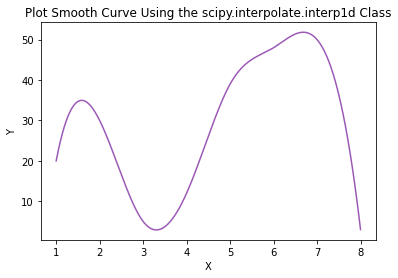

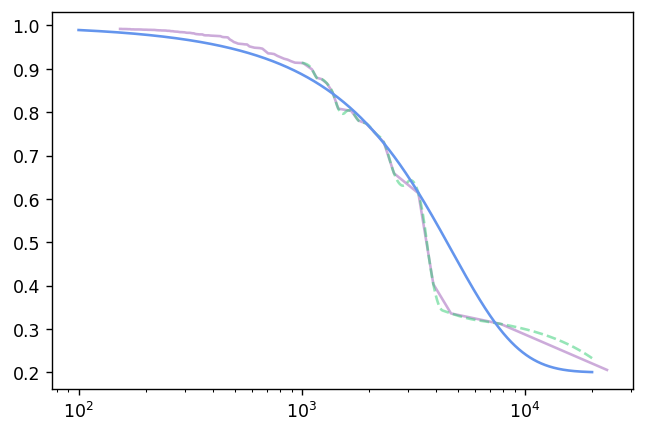

In [178]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Dataset
x=np.array([1, 2, 3, 4, 5, 6, 7, 8])
y=np.array([20, 30, 5, 12, 39, 48, 50, 3])

cubic_interpolation_model = interp1d(x, y, kind = "cubic")

# Plotting the Graph
X_=np.linspace(x.min(), x.max(), 500)
Y_=cubic_interpolation_model(X_)

plt.plot(X_, Y_)
plt.title("Plot Smooth Curve Using the scipy.interpolate.interp1d Class")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


plt.figure(dpi=125)
pi_rej = np.divide(1,(1-GeV40_false_e), where=(GeV40_false_e!=1), out=0*GeV40_false_e)

keeps = (pi_rej!=0)#np.isinf(, where=False)
_,idx = np.unique(pi_rej[keeps], return_index=True)

pi_rej = pi_rej[keeps][idx]
e_eff = (1-GeV40_true_e)[keeps][idx]

plt.plot(pi_rej,
         e_eff, 
         alpha=0.5)

cubic_GeV40 = interp1d(pi_rej, e_eff, kind = "quadratic", assume_sorted=1)

plt.plot(np.arange(1e3,2e4), cubic_GeV40(np.arange(1e3,2e4)), 
         alpha=0.5, linestyle="dashed")

plt.plot(np.arange(1e2,2e4), 12/(10+5*np.exp(4e-4*np.arange(1e2,2e4)))+.2)
plt.xscale("log")

[2.98095087e+00 1.01501596e+01 1.25676742e-05 3.91814540e+00
 6.99021379e-01]
[1.62730057e+05 5.54093225e+05 6.86140405e-01 1.79649867e-01
 1.16964053e-02]
[5.45899830e+06 5.45896071e+06 5.45956549e+06 4.58507402e+00
 1.67325430e+00]


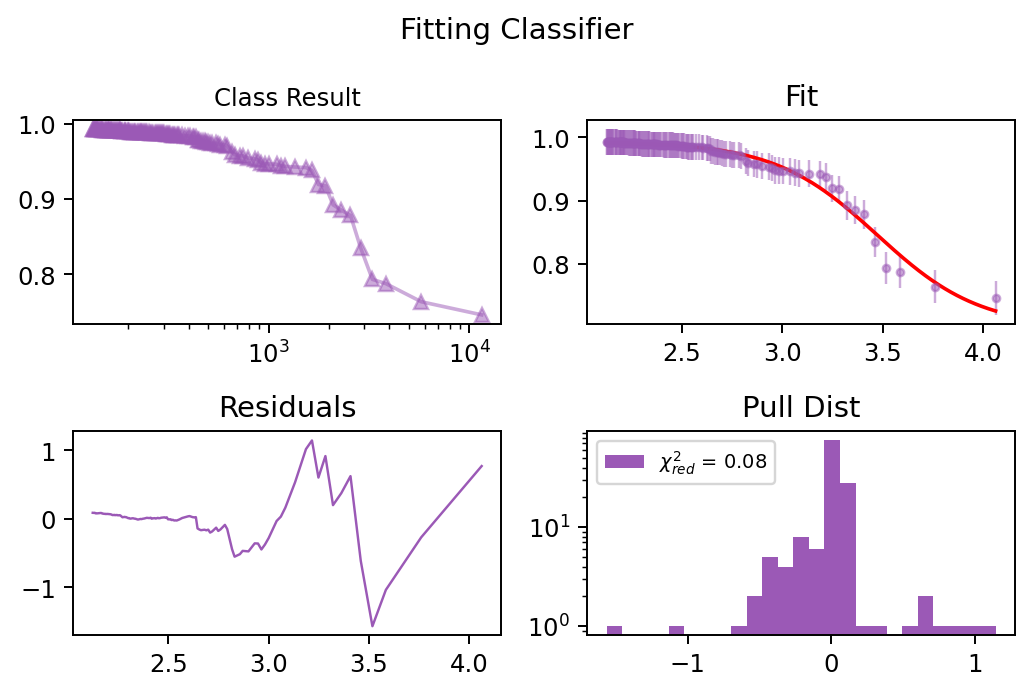

In [201]:
def Sigmoid(x, A, a,b,c, d):
    return A/(a + b*np.exp(c*x)) + d


pi_rej = np.divide(1,(1-GeV35_false_e), where=(GeV35_false_e!=1), out=0*GeV35_false_e)

keeps = (pi_rej!=0)#np.isinf(, where=False)
_,idx = np.unique(pi_rej[keeps], return_index=True)

pi_rej = pi_rej[keeps][idx]
e_eff = (1-GeV35_true_e)[keeps][idx]

plt.figure(dpi=175)
plt.suptitle(f"Fitting Classifier")

##Get Hist
plt.subplot(2, 2, 1)
plt.title("Class Result", fontsize=10)
plt.plot(pi_rej,
         e_eff, 
         alpha=0.5, marker="^")
plt.xscale("log")


##Fit Peaks

#Fit minimum x val
fit_min = 10
fit_max = 1e4

#Fit inputs
fit_function = Sigmoid
fit_x = np.log10(pi_rej)
fit_vals = e_eff
errors = .02/e_eff

##Fit Dist
pars, cov = scipy.optimize.curve_fit(fit_function, #Function
                                     fit_x, fit_vals, #x, y values
                                     sigma=errors, #uncertainties
                                     p0=[12, 10, 5, 4e-4, .2], 
                                     #bounds=([0,0,0,200,0],[1e5,1e5,1e5,600,1e5]),
                                     
                                     #background_landau
                                     #p0=[2,.3,20, 10,.02,400, 50], 
                                     #bounds=([0,0,-100, 0,.0001,0.001, 0],[1e20,1e12,1e12, 1e5,1,5e6, 100]),
                                     maxfev=3*10**5
                                    )

##Show Fit
plt.subplot(2, 2, 2)
plt.title("Fit")

x = np.logspace(np.log10(fit_x[0]), np.log10(fit_x[-1]), 1000)
plt.errorbar(fit_x, fit_vals, yerr=errors, fmt="o", ms=3, elinewidth=1, alpha=0.5)
#plt.vlines(pars[-2], 0, np.max(fit_vals)*1.2, color="cornflowerblue", label=f"MIP Peak: {pars[-2]:.0f} ({np.sqrt(cov.diagonal())[-2]:.0f})")
plt.plot(x, fit_function(x, *pars), color="red")
#plt.legend(fontsize=6)

##Plot Residuals
residuals = (fit_vals-fit_function(fit_x, *pars))/errors
plt.subplot(2, 2, 3)
plt.title("Residuals")
plt.plot(fit_x, residuals, lw=1)

##Pull Dist
plt.subplot(2, 2, 4)
plt.title("Pull Dist")
red = "{red}"
plt.hist(residuals, 25, label=f"$\chi_{red}^2$ = {np.sum(residuals**2)/len(residuals):.2f}")
plt.yscale("log")
plt.legend(prop={"size":8})


plt.tight_layout()
#plt.savefig(f"Plots/Run_Plots/Run{run_num}_ShowerTop_MIPFit.pdf")

print(pars)
print(np.sqrt(cov.diagonal()))
print(np.sqrt(cov.diagonal())/np.abs(pars)*100)

<timed exec>:7: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:8: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:9: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:10: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:11: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:12: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:13: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:14: RuntimeWarning: divide by zero encountered in true_divide


CPU times: user 361 ms, sys: 256 ms, total: 617 ms
Wall time: 384 ms


[]

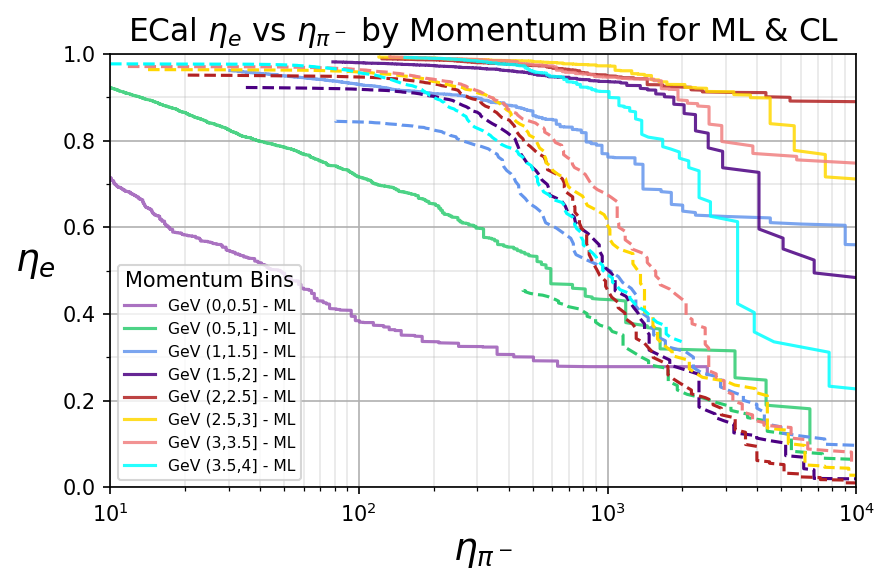

In [23]:
%%time

fig, ax = plt.subplots(dpi=150)#, figsize=(8,5))
plt.title("ECal $\eta_e$ vs $\eta_{\pi^-}$ by Momentum Bin for ML & CL", fontsize=15)#$\pi^-$ Rejection")
plt.ylabel("$\eta_e$", fontsize=18, rotation=0)
plt.xlabel("$\eta_{\pi^-}$", fontsize=18)


plt.plot(1/(1-GeV05_false_e),1-GeV05_true_e, label="GeV (0,0.5] - ML", alpha=.85)
plt.plot(1/(1-GeV10_false_e),1-GeV10_true_e, label="GeV (0.5,1] - ML", alpha=.85)
plt.plot(1/(1-GeV15_false_e),1-GeV15_true_e, label="GeV (1,1.5] - ML", alpha=.85)
plt.plot(1/(1-GeV20_false_e),1-GeV20_true_e, label="GeV (1.5,2] - ML", alpha=.85)
plt.plot(1/(1-GeV25_false_e),1-GeV25_true_e, label="GeV (2,2.5] - ML", alpha=.85)
plt.plot(1/(1-GeV30_false_e),1-GeV30_true_e, label="GeV (2.5,3] - ML", alpha=.85)
plt.plot(1/(1-GeV35_false_e),1-GeV35_true_e, label="GeV (3,3.5] - ML", alpha=.85)
plt.plot(1/(1-GeV40_false_e),1-GeV40_true_e, label="GeV (3.5,4] - ML", alpha=.85)


##Plot Spencer's Cuts
slices = [(0,0.5), (0.5,1), (1,1.5), (1.5,2), (2,2.5), (2.5,3), (3,3.5), (3.5,4)]


CL0, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[0][0]) & (eff_df["Slice End"] == slices[0][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[0][0]) & (eff_df["Slice End"] == slices[0][1])]["Electron Efficiency"], 
                linestyle="dashed")

CL1, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[1][0]) & (eff_df["Slice End"] == slices[1][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[1][0]) & (eff_df["Slice End"] == slices[1][1])]["Electron Efficiency"], 
                linestyle="dashed")

CL2, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[2][0]) & (eff_df["Slice End"] == slices[2][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[2][0]) & (eff_df["Slice End"] == slices[2][1])]["Electron Efficiency"], 
                linestyle="dashed")

CL3, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[3][0]) & (eff_df["Slice End"] == slices[3][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[3][0]) & (eff_df["Slice End"] == slices[3][1])]["Electron Efficiency"], 
                linestyle="dashed")

CL4, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[4][0]) & (eff_df["Slice End"] == slices[4][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[4][0]) & (eff_df["Slice End"] == slices[4][1])]["Electron Efficiency"], 
                linestyle="dashed")

CL5, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[5][0]) & (eff_df["Slice End"] == slices[5][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[5][0]) & (eff_df["Slice End"] == slices[5][1])]["Electron Efficiency"], 
                linestyle="dashed")

CL6, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[6][0]) & (eff_df["Slice End"] == slices[6][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[6][0]) & (eff_df["Slice End"] == slices[6][1])]["Electron Efficiency"], 
                linestyle="dashed")

CL7, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[7][0]) & (eff_df["Slice End"] == slices[7][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[7][0]) & (eff_df["Slice End"] == slices[7][1])]["Electron Efficiency"], 
                linestyle="dashed")


#add legend to plot
plt.legend(title="Momentum Bins", fontsize=7.5, loc="lower left", ncol=1)#,bbox_to_anchor = (1.225, 0.6), loc='center right')#[handles[idx] for idx in order],[labels[idx] for idx in order])

#plt.legend(((ML0, CL0), (ML1, CL1), (ML2, CL2), (ML3, CL3), (ML4, CL4), (ML5, CL5), (ML6, CL6), (ML7, CL7)), 
#           ("GeV (0,0.5]", "GeV (0.5,1]", "GeV (1,1.5]", "GeV (1.5,2]", "GeV (2,2.5]", "GeV (2.5,3]", "GeV (3,3.5]", "GeV (3.5,4]"),
#           handler_map={tuple: HandlerTuple(ndivide=2)},
#           title="Momentum Bins", fontsize=9, loc="lower left", 
#           numpoints=1, labelspacing=.75)

#ax.set_xticks(np.arange(0,1.025,.01), minor=1)
#ax.set_yticks(np.arange(0,1.025,.01), minor=1)

#plt.xlim(10**2,10**6)
plt.xlim(10,10**4)
plt.xscale("log")

plt.ylim(0,1.001)
#plt.yscale("log")
plt.yticks(np.arange(0,1.1,.2))
ax.set_yticks(np.arange(.2,1.1,.1), minor=1)
ax.yaxis.set_label_coords(-.1,.475)

plt.grid()
plt.grid(axis="both", which="minor", alpha=0.3)
#plt.savefig("Plots/MLPID_eEff_PiRej_Pencil_MomentumSlices_ML_Classical.pdf")
#plt.savefig("Plots/ModelCompare_eEff_PiRej_Pencil_MomentumSlices_All_Zoom.pdf")

plt.tight_layout()
plt.plot()

<timed exec>:9: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:13: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:17: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:21: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:25: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:29: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:33: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:37: RuntimeWarning: divide by zero encountered in true_divide


CPU times: user 502 ms, sys: 358 ms, total: 860 ms
Wall time: 405 ms


[]

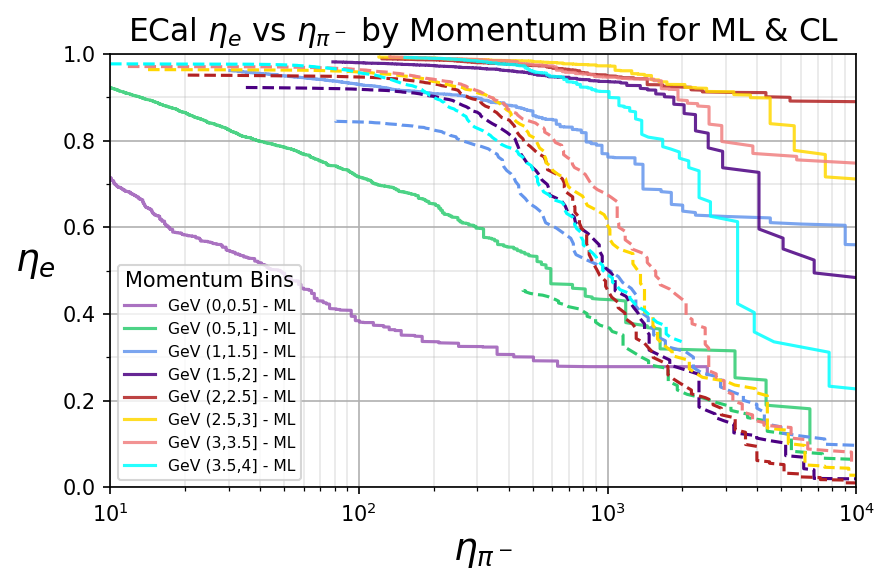

In [202]:
%%time

fig, ax = plt.subplots(dpi=150)#, figsize=(8,5))
plt.title("ECal $\eta_e$ vs $\eta_{\pi^-}$ by Momentum Bin for ML & CL", fontsize=15)#$\pi^-$ Rejection")
plt.ylabel("$\eta_e$", fontsize=18, rotation=0)
plt.xlabel("$\eta_{\pi^-}$", fontsize=18)


#plt.plot(1/(1-full_false_e),1-full_true_e, label="Full", c="black")

ML0, = plt.plot(1/(1-GeV05_false_e),1-GeV05_true_e, 
                label="GeV (0,0.5] - ML", 
                #marker=".", ms=2,
                alpha=.85)#, c="fuchsia")
ML1, = plt.plot(1/(1-GeV10_false_e),1-GeV10_true_e, 
                label="GeV (0.5,1] - ML", 
                #marker=".", ms=2,
                alpha=.85)#, c="cornflowerblue")
ML2, = plt.plot(1/(1-GeV15_false_e),1-GeV15_true_e, 
                label="GeV (1,1.5] - ML", 
                #marker=".", ms=2,
                alpha=.85)
ML3, = plt.plot(1/(1-GeV20_false_e),1-GeV20_true_e, 
                label="GeV (1.5,2] - ML", 
                #marker=".", ms=2,
                alpha=.85)#, c="#2ecc71")
ML4, = plt.plot(1/(1-GeV25_false_e),1-GeV25_true_e, 
                label="GeV (2,2.5] - ML", 
                #marker=".", ms=2,
                alpha=.85)
ML5, = plt.plot(1/(1-GeV30_false_e),1-GeV30_true_e, 
                label="GeV (2.5,3] - ML", 
                #marker=".", ms=2,
                alpha=.85)
ML6, = plt.plot(1/(1-GeV35_false_e),1-GeV35_true_e, 
                label="GeV (3,3.5] - ML", 
                #marker=".", ms=2,
                alpha=.85)
ML7, = plt.plot(1/(1-GeV40_false_e),1-GeV40_true_e, 
                label="GeV (3.5,4] - ML", 
                #marker=".", ms=2,
                alpha=.85)#, c="red")


##Plot Spencer's Cuts
slices = [(0,0.5), (0.5,1), (1,1.5), (1.5,2), (2,2.5), (2.5,3), (3,3.5), (3.5,4)]


CL0, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[0][0]) & (eff_df["Slice End"] == slices[0][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[0][0]) & (eff_df["Slice End"] == slices[0][1])]["Electron Efficiency"], 
                linestyle="dashed")

CL1, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[1][0]) & (eff_df["Slice End"] == slices[1][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[1][0]) & (eff_df["Slice End"] == slices[1][1])]["Electron Efficiency"], 
                linestyle="dashed")

CL2, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[2][0]) & (eff_df["Slice End"] == slices[2][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[2][0]) & (eff_df["Slice End"] == slices[2][1])]["Electron Efficiency"], 
                linestyle="dashed")

CL3, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[3][0]) & (eff_df["Slice End"] == slices[3][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[3][0]) & (eff_df["Slice End"] == slices[3][1])]["Electron Efficiency"], 
                linestyle="dashed")

CL4, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[4][0]) & (eff_df["Slice End"] == slices[4][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[4][0]) & (eff_df["Slice End"] == slices[4][1])]["Electron Efficiency"], 
                linestyle="dashed")

CL5, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[5][0]) & (eff_df["Slice End"] == slices[5][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[5][0]) & (eff_df["Slice End"] == slices[5][1])]["Electron Efficiency"], 
                linestyle="dashed")

CL6, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[6][0]) & (eff_df["Slice End"] == slices[6][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[6][0]) & (eff_df["Slice End"] == slices[6][1])]["Electron Efficiency"], 
                linestyle="dashed")

CL7, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[7][0]) & (eff_df["Slice End"] == slices[7][1])]["Pion Rejection"]), 
                eff_df[(eff_df["Slice Begin"] == slices[7][0]) & (eff_df["Slice End"] == slices[7][1])]["Electron Efficiency"], 
                linestyle="dashed")


#add legend to plot
plt.legend(title="Momentum Bins", fontsize=7.5, loc="lower left", ncol=1)#,bbox_to_anchor = (1.225, 0.6), loc='center right')#[handles[idx] for idx in order],[labels[idx] for idx in order])

#plt.legend(((ML0, CL0), (ML1, CL1), (ML2, CL2), (ML3, CL3), (ML4, CL4), (ML5, CL5), (ML6, CL6), (ML7, CL7)), 
#           ("GeV (0,0.5]", "GeV (0.5,1]", "GeV (1,1.5]", "GeV (1.5,2]", "GeV (2,2.5]", "GeV (2.5,3]", "GeV (3,3.5]", "GeV (3.5,4]"),
#           handler_map={tuple: HandlerTuple(ndivide=2)},
#           title="Momentum Bins", fontsize=9, loc="lower left", 
#           numpoints=1, labelspacing=.75)

#ax.set_xticks(np.arange(0,1.025,.01), minor=1)
#ax.set_yticks(np.arange(0,1.025,.01), minor=1)

#plt.xlim(10**2,10**6)
plt.xlim(10,10**4)
plt.xscale("log")

plt.ylim(0,1.001)
#plt.yscale("log")
plt.yticks(np.arange(0,1.1,.2))
ax.set_yticks(np.arange(.2,1.1,.1), minor=1)
ax.yaxis.set_label_coords(-.1,.475)

plt.grid()
plt.grid(axis="both", which="minor", alpha=0.3)
plt.savefig("Plots/MLPID_eEff_PiRej_Pencil_MomentumSlices_ML_Classical_New.pdf")
#plt.savefig("Plots/ModelCompare_eEff_PiRej_Pencil_MomentumSlices_All_Zoom.pdf")

plt.tight_layout()
plt.plot()

CPU times: user 222 ms, sys: 134 ms, total: 356 ms
Wall time: 160 ms


<timed exec>:9: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:13: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:17: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:21: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:25: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:29: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:33: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:37: RuntimeWarning: divide by zero encountered in true_divide


[]

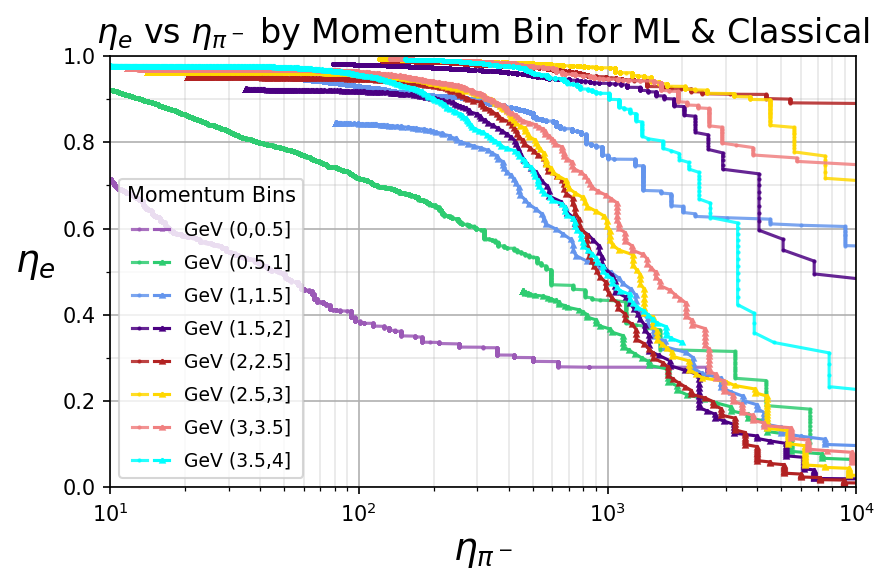

In [198]:
%%time

fig, ax = plt.subplots(dpi=150)#, figsize=(8,5))
plt.title("$\eta_e$ vs $\eta_{\pi^-}$ by Momentum Bin for ML & Classical", fontsize=16)#$\pi^-$ Rejection")
plt.ylabel("$\eta_e$", fontsize=18, rotation=0)
plt.xlabel("$\eta_{\pi^-}$", fontsize=18)


#plt.plot(1/(1-full_false_e),1-full_true_e, label="Full", c="black")

ML0, = plt.plot(1/(1-GeV05_false_e),1-GeV05_true_e, 
               #label="GeV (0,0.5] - ML", 
                marker=".", ms=2,
               alpha=.85)#, c="fuchsia")
ML1, = plt.plot(1/(1-GeV10_false_e),1-GeV10_true_e, 
               #label="GeV (0.5,1] - ML", 
                marker=".", ms=2,
               alpha=.85)#, c="cornflowerblue")
ML2, = plt.plot(1/(1-GeV15_false_e),1-GeV15_true_e, 
               #label="GeV (1,1.5] - ML", 
                marker=".", ms=2,
               alpha=.85)
ML3, = plt.plot(1/(1-GeV20_false_e),1-GeV20_true_e, 
               #label="GeV (1.5,2] - ML", 
                marker=".", ms=2,
               alpha=.85)#, c="#2ecc71")
ML4, = plt.plot(1/(1-GeV25_false_e),1-GeV25_true_e, 
               #label="GeV (2,2.5] - ML", 
                marker=".", ms=2,
               alpha=.85)
ML5, = plt.plot(1/(1-GeV30_false_e),1-GeV30_true_e, 
               #label="GeV (2.5,3] - ML", 
                marker=".", ms=2,
               alpha=.85)
ML6, = plt.plot(1/(1-GeV35_false_e),1-GeV35_true_e, 
               #label="GeV (3,3.5] - ML", 
                marker=".", ms=2,
               alpha=.85)
ML7, = plt.plot(1/(1-GeV40_false_e),1-GeV40_true_e, 
               #label="GeV (3.5,4] - ML", 
                marker=".", ms=2,
               alpha=.85)#, c="red")


##Plot Spencer's Cuts
slices = [(0,0.5), (0.5,1), (1,1.5), (1.5,2), (2,2.5), (2.5,3), (3,3.5), (3.5,4)]


CL0, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[0][0]) & (eff_df["Slice End"] == slices[0][1])]["Pion Rejection"]), 
                   eff_df[(eff_df["Slice Begin"] == slices[0][0]) & (eff_df["Slice End"] == slices[0][1])]["Electron Efficiency"], 
                   marker="^", ms=1)

CL1, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[1][0]) & (eff_df["Slice End"] == slices[1][1])]["Pion Rejection"]), 
                   eff_df[(eff_df["Slice Begin"] == slices[1][0]) & (eff_df["Slice End"] == slices[1][1])]["Electron Efficiency"], 
                   marker="^", ms=2)

CL2, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[2][0]) & (eff_df["Slice End"] == slices[2][1])]["Pion Rejection"]), 
                   eff_df[(eff_df["Slice Begin"] == slices[2][0]) & (eff_df["Slice End"] == slices[2][1])]["Electron Efficiency"], 
                   marker="^", ms=2)

CL3, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[3][0]) & (eff_df["Slice End"] == slices[3][1])]["Pion Rejection"]), 
                   eff_df[(eff_df["Slice Begin"] == slices[3][0]) & (eff_df["Slice End"] == slices[3][1])]["Electron Efficiency"], 
                   marker="^", ms=2)

CL4, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[4][0]) & (eff_df["Slice End"] == slices[4][1])]["Pion Rejection"]), 
                   eff_df[(eff_df["Slice Begin"] == slices[4][0]) & (eff_df["Slice End"] == slices[4][1])]["Electron Efficiency"], 
                   marker="^", ms=2)

CL5, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[5][0]) & (eff_df["Slice End"] == slices[5][1])]["Pion Rejection"]), 
                   eff_df[(eff_df["Slice Begin"] == slices[5][0]) & (eff_df["Slice End"] == slices[5][1])]["Electron Efficiency"], 
                   marker="^", ms=2)

CL6, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[6][0]) & (eff_df["Slice End"] == slices[6][1])]["Pion Rejection"]), 
                   eff_df[(eff_df["Slice Begin"] == slices[6][0]) & (eff_df["Slice End"] == slices[6][1])]["Electron Efficiency"], 
                   marker="^", ms=2)

CL7, = plt.plot(1/(1-eff_df[(eff_df["Slice Begin"] == slices[7][0]) & (eff_df["Slice End"] == slices[7][1])]["Pion Rejection"]), 
                   eff_df[(eff_df["Slice Begin"] == slices[7][0]) & (eff_df["Slice End"] == slices[7][1])]["Electron Efficiency"], 
                   marker="^", ms=2)


#add legend to plot
#plt.legend(title="Momentum Bins", fontsize=7.5, loc="lower left", ncol=2)#,bbox_to_anchor = (1.225, 0.6), loc='center right')#[handles[idx] for idx in order],[labels[idx] for idx in order])

plt.legend(((ML0, CL0), (ML1, CL1), (ML2, CL2), (ML3, CL3), (ML4, CL4), (ML5, CL5), (ML6, CL6), (ML7, CL7)), 
           ("GeV (0,0.5]", "GeV (0.5,1]", "GeV (1,1.5]", "GeV (1.5,2]", "GeV (2,2.5]", "GeV (2.5,3]", "GeV (3,3.5]", "GeV (3.5,4]"),
           handler_map={tuple: HandlerTuple(ndivide=2)},
           title="Momentum Bins", fontsize=9, loc="lower left", 
           numpoints=1, labelspacing=.75)

#ax.set_xticks(np.arange(0,1.025,.01), minor=1)
#ax.set_yticks(np.arange(0,1.025,.01), minor=1)

#plt.xlim(10**2,10**6)
plt.xlim(10,10**4)
plt.xscale("log")

plt.ylim(0,1.001)
#plt.yscale("log")
plt.yticks(np.arange(0,1.1,.2))
ax.set_yticks(np.arange(.2,1.1,.1), minor=1)
ax.yaxis.set_label_coords(-.1,.475)

plt.grid()
plt.grid(axis="both", which="minor", alpha=0.3)
#plt.savefig("Plots/MLPID_eEff_PiRej_Pencil_MomentumSlices_ML_Classical.pdf")
#plt.savefig("Plots/ModelCompare_eEff_PiRej_Pencil_MomentumSlices_All_Zoom.pdf")

plt.tight_layout()
plt.plot()

# Spencer Copy

In [4]:
eff_df = pd.DataFrame(columns=['Slice Begin', 'Slice End', 'b', 'Electron Efficiency', 'Pion Rejection', 
                                        'Electrons Kept', 'Total Electrons', 'Charged Pions Kept', 'Charged Pions Rejected', 'Total Charged Pions'])

In [5]:
%%time

eff_df = eff_df.drop(eff_df.index)

# Momentum Slices
slices = [(0,0.5), (0.5,1), (1,1.5), (1.5,2), (2,2.5), (2.5,3), (3,3.5), (3.5,4),
         (4,4.5), (4.5,5), (5,5.5), (5.5,6), (6,6.5), (6.5,7)]

# 1 dimensional cuts
shower_cut = sim_df["ShowerSum"] >= 57
pre_shower_cut = sim_df["PreShSum"] >= 10

# Diagonal cut is y = mx + b
# y - mx = b  
m = -1/3

for pair in slices:
    print(pair)
    # Decides how many different cuts to try and where to place them
    b = np.arange(1, 200, 0.5)
    
    mom_slice = (sim_df["p"] > pair[0]) & (sim_df["p"] <= pair[1])
    
    pre_sel_events = sim_df[(mom_slice) & (shower_cut) & (pre_shower_cut)]#.sample(frac=.3)
    
    
    # Count occurrences of each unique value in the 'pid' column
    value_counts = sim_df[mom_slice]['pid'].value_counts()
    
    # Get the count of events with labels 211 and -211 and sum them
    count_minus211 = value_counts[-211] if -211 in value_counts else 0
    total_pi = count_minus211

    # Get the count of events with the label 11
    total_elec = value_counts[11] if 11 in value_counts else 0
    
    # Loops through those cuts and stores results
    for b_val in b:
        diagonal_cut = (pre_sel_events["PreShSum"] - m*pre_sel_events["ShowerSum"]) >= b_val
        
        # Make the required cuts on the data frame
        selected_events =  pre_sel_events[(diagonal_cut)]
        
        """
        Plot a cut
        if (pair[0] == 1) and (b_val == 30):
            plt.figure(dpi = 150)
            
            sns.scatterplot(data = selected_events, x = "ShowerSum", y = "PreShSum", hue = 'pid', palette = "tab10", alpha = 0.4)
            
            plt.show()
        """     

        # Get count of selected electrons and pions
        num_elec = selected_events[selected_events["pid"] == 11].shape[0]
        num_pi = selected_events[(selected_events["pid"] == -211)].shape[0]
        
        # Avoid divide by 0 errors
        if total_elec != 0:
            elec_eff = num_elec/total_elec
        else:
            elec_eff = 1
            
        if total_pi != 0:
            pi_rej = 1 - (num_pi)/(total_pi)
        else: 
            pi_rej = 1
    
        
        eff_df = eff_df.append({'Slice Begin': pair[0],
                                'Slice End': pair[1],
                                'b': b_val,
                                'Electron Efficiency': elec_eff,
                                'Pion Rejection': pi_rej,
                                'Electrons Kept': num_elec,
                                'Total Electrons': total_elec,
                                'Charged Pions Kept': num_pi,
                                'Charged Pions Rejected': total_pi - num_pi,
                                'Total Charged Pions': total_pi},
                               ignore_index=True)
        
print(eff_df["Electron Efficiency"].max())
eff_df

(0, 0.5)
(0.5, 1)
(1, 1.5)
(1.5, 2)
(2, 2.5)
(2.5, 3)
(3, 3.5)
(3.5, 4)
(4, 4.5)
(4.5, 5)
(5, 5.5)
(5.5, 6)
(6, 6.5)
(6.5, 7)
0.9898039476454877
CPU times: user 2min 33s, sys: 17 s, total: 2min 50s
Wall time: 2min 49s


,Slice Begin,Slice End,b,Electron Efficiency,Pion Rejection,Electrons Kept,Total Electrons,Charged Pions Kept,Charged Pions Rejected,Total Charged Pions
0,0.0,0.5,1.0,0.000142,1.000000,4.0,28077.0,0.0,8109.0,8109.0
1,0.0,0.5,1.5,0.000142,1.000000,4.0,28077.0,0.0,8109.0,8109.0
2,0.0,0.5,2.0,0.000142,1.000000,4.0,28077.0,0.0,8109.0,8109.0
3,0.0,0.5,2.5,0.000142,1.000000,4.0,28077.0,0.0,8109.0,8109.0
4,0.0,0.5,3.0,0.000142,1.000000,4.0,28077.0,0.0,8109.0,8109.0
...,...,...,...,...,...,...,...,...,...,...
5567,6.5,7.0,197.5,0.987266,0.960209,89082.0,90231.0,3262.0,78717.0,81979.0
5568,6.5,7.0,198.0,0.987222,0.960465,89078.0,90231.0,3241.0,78738.0,81979.0
5569,6.5,7.0,198.5,0.987211,0.960929,89077.0,90231.0,3203.0,78776.0,81979.0
5570,6.5,7.0,199.0,0.987166,0.961222,89073.0,90231.0,3179.0,78800.0,81979.0


## Efficiency Curves

### Pion Rejection vs Electron Efficiency

[]

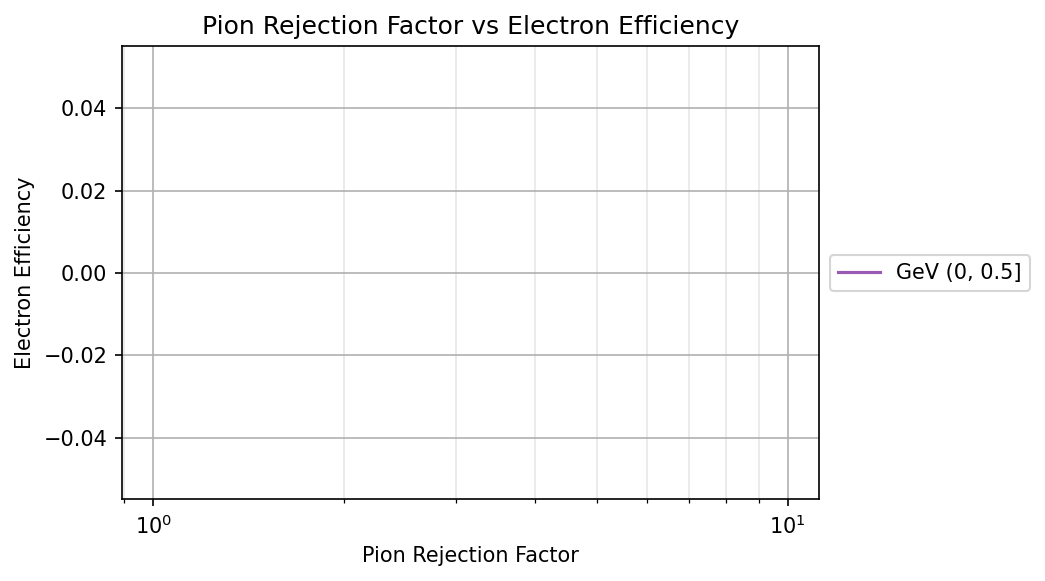

In [118]:
plt.figure(dpi = 150)

slices = [(0,0.5), (0.5,1), (1,1.5), (1.5,2), (2,2.5), (2.5,3), (3,3.5), (3.5,4)]#,
         #(4,4.5), (4.5,5), (5,5.5), (5.5,6), (6,6.5), (6.5,7)]

for pair in slices[0:1]:
    
    slice = (eff_df["Slice Begin"] == pair[0]) & (eff_df["Slice End"] == pair[1])

    plt.plot(1/(1-eff_df[slice]["Pion Rejection"]), eff_df[slice]["Electron Efficiency"], label=f"GeV ({pair[0]}, {pair[1]}]")


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("Pion Rejection Factor")
plt.ylabel("Electron Efficiency")

#Show gridlines
plt.grid()
plt.grid(axis="both", which="minor", alpha=0.3)

#plt.xlim(0, 2500)
plt.title("Pion Rejection Factor vs Electron Efficiency")

plt.xscale("log")

plt.plot()